# XGBoost Most Important

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb

import matplotlib.pyplot as plt 
import seaborn as sns
import ppscore as pps

## Read in and Split Data

In [2]:
# read in data
data = pd.read_csv('../data/business_closures_data.csv')
data.head()

,merchants_all,FIPS,State,County,Deaths,Years of Potential Life Lost Rate,% Fair or Poor Health,Average Number of Physically Unhealthy Days,Average Number of Mentally Unhealthy Days,% Low Birthweight,...,% Below Poverty,Median Household Income,% No College Degree,Unemployment Rate,% Not in Labor Force,% Jobs in Leisure and Hospitality,% Part-time,% Self-Employed,Presence of Water Violation (dummy Y/N),Other Primary Care Provider Ratio (:1)
0,-1.000000,10001,Delaware,Kent,2425,7952.454872,18.955716,4.095031,4.679157,9.144445,...,12.7,58804,14.733088,4.2,43.431803,12.127023,40.681663,7.656197,1,1198
1,-1.000000,10003,Delaware,New Castle,6824,7701.203301,16.799934,3.772635,4.172026,8.913882,...,10.4,76076,20.911183,3.7,33.299407,10.139226,38.804566,6.999494,0,627
2,-0.999999,10005,Delaware,Sussex,3425,8084.788322,17.813709,3.721060,4.132735,7.789606,...,12.1,64839,16.125402,3.8,42.295823,17.822374,39.846865,12.649395,1,1390
3,0.159189,1001,Alabama,Autauga,791,8128.591190,20.882987,4.743889,4.654031,8.619529,...,12.1,58233,16.107796,2.7,40.454576,14.216260,39.604710,7.283256,0,2527
4,-1.000000,1003,Alabama,Baldwin,2967,7354.122530,17.509134,4.224519,4.304056,8.345003,...,10.1,59871,21.044656,2.7,43.511495,20.823355,40.364194,12.669969,0,1787


In [3]:
X = data.drop(["FIPS", "merchants_all", "State", "County"], axis=1)
y = pd.DataFrame(data["merchants_all"])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
len(X.columns)

98

## Dummy Baseline

In [6]:
y_train_mean = y_train.mean()
y_train_mean

merchants_all    48.4539
dtype: float64

In [7]:
(((y_test - y_train_mean)**2).sum())**(.5)

merchants_all    968.88607
dtype: float64

## XGBoost and Feature Importance

In [8]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [9]:
"""
Hyperparameter Tuning from 
https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
"""

params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
    'eval_metric':"rmse"
}

In [10]:
num_boost_round = 999

In [11]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:52.73922
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:97.44992
[2]	Test-rmse:135.46007
[3]	Test-rmse:167.76967
[4]	Test-rmse:195.23297
[5]	Test-rmse:218.57697
[6]	Test-rmse:238.41986
[7]	Test-rmse:255.28626
[8]	Test-rmse:269.62247
[9]	Test-rmse:281.80829
[10]	Test-rmse:292.16595
Stopping. Best iteration:
[0]	Test-rmse:52.73922



In [12]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,1362.860922,621.373618,1049.91007,1463.803396


In [13]:
cv_results['test-rmse-mean'].min()

1049.91007

### Tune max_depth and min_child_weight

In [14]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

In [15]:
# Define initial best params and rmse
min_rmse = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best rmse
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trmse {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, rmse: {}".format(best_params[0], best_params[1], min_rmse))

CV with max_depth=9, min_child_weight=5
	rmse 1000.7993194000001 for 0 rounds
CV with max_depth=9, min_child_weight=6
	rmse 981.5611634 for 0 rounds
CV with max_depth=9, min_child_weight=7
	rmse 928.3967858000002 for 0 rounds
CV with max_depth=10, min_child_weight=5
	rmse 1000.7992676 for 0 rounds
CV with max_depth=10, min_child_weight=6
	rmse 981.5608156000001 for 0 rounds
CV with max_depth=10, min_child_weight=7
	rmse 928.3967835999999 for 0 rounds
CV with max_depth=11, min_child_weight=5
	rmse 1000.7994874 for 0 rounds
CV with max_depth=11, min_child_weight=6
	rmse 981.5608888 for 0 rounds
CV with max_depth=11, min_child_weight=7
	rmse 928.396927 for 0 rounds
Best params: 10, 7, rmse: 928.3967835999999


In [16]:
params['max_depth'] = 10
params['min_child_weight'] = 7

### Tune subsample and colsample

In [17]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [18]:
min_rmse = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trmse {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample)
print("Best params: {}, {}, rmse: {}".format(best_params[0], best_params[1], min_rmse))

CV with subsample=1.0, colsample=1.0
	rmse 928.3967835999999 for 0 rounds
CV with subsample=1.0, colsample=0.9
	rmse 928.4688706000001 for 0 rounds
CV with subsample=1.0, colsample=0.8
	rmse 928.4683884 for 0 rounds
CV with subsample=1.0, colsample=0.7
	rmse 928.3119474000001 for 0 rounds
CV with subsample=0.9, colsample=1.0
	rmse 941.7180420000001 for 0 rounds
CV with subsample=0.9, colsample=0.9
	rmse 941.7156794 for 0 rounds
CV with subsample=0.9, colsample=0.8
	rmse 941.6119041999998 for 0 rounds
CV with subsample=0.9, colsample=0.7
	rmse 941.4537918 for 0 rounds
CV with subsample=0.8, colsample=1.0
	rmse 962.9173645999999 for 0 rounds
CV with subsample=0.8, colsample=0.9
	rmse 962.9605142 for 0 rounds
CV with subsample=0.8, colsample=0.8
	rmse 962.8527774 for 0 rounds
CV with subsample=0.8, colsample=0.7
	rmse 962.8494584 for 0 rounds
CV with subsample=0.7, colsample=1.0
	rmse 970.7062470000001 for 0 rounds
CV with subsample=0.7, colsample=0.9
	rmse 970.7069078000001 for 0 rounds


In [19]:
params['subsample'] = 1.0
params['colsample_bytree'] = 0.7

### Tune eta

In [20]:
min_rmse = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    cv_results = xgb.cv(params, dtrain, num_boost_round=num_boost_round, seed=42, nfold=5, metrics=['rmse'], early_stopping_rounds=10)
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trmse {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
print("Best params: {}, rmse: {}".format(best_params, min_rmse))

CV with eta=0.3
	rmse 928.3119468000001 for 0 rounds

CV with eta=0.2
	rmse 900.6864014 for 0 rounds

CV with eta=0.1
	rmse 875.3382423999999 for 0 rounds

CV with eta=0.05
	rmse 864.4152126000001 for 0 rounds

CV with eta=0.01
	rmse 858.2609433999999 for 0 rounds

CV with eta=0.005
	rmse 857.9120336 for 0 rounds

Best params: 0.005, rmse: 857.9120336


In [21]:
params['eta'] = .005

In [22]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:1.68835
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:3.66044
[2]	Test-rmse:4.34184
[3]	Test-rmse:5.80248
[4]	Test-rmse:7.96625
[5]	Test-rmse:7.97419
[6]	Test-rmse:8.03401
[7]	Test-rmse:9.39777
[8]	Test-rmse:9.42743
[9]	Test-rmse:11.70591
[10]	Test-rmse:11.72561
Stopping. Best iteration:
[0]	Test-rmse:1.68835



In [23]:
print("Best RMSE: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

Best RMSE: 1.69 in 1 rounds


### Get and save best model

In [24]:
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[0]	Test-rmse:1.68835


In [25]:
best_model.save_model("my_model.model")

In [26]:
(mean_squared_error(best_model.predict(dtest), y_test))**.5

1.6883500248613863

### Feature Importance

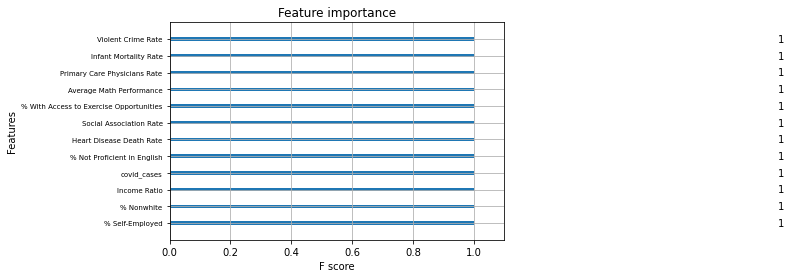

In [27]:
xgb.plot_importance(best_model)
plt.rcParams['figure.figsize'] = [50, 50]
plt.yticks(size = 7)
plt.show()

### The following are the 12 most important features:
1. Violent Crime Rate
2. Infant Mortality Rate
3. Primary Care Physicians Rate
4. Average Math Performance
5. % With Access to Exercise Opportunities
6. Social Association Rate
7. Heart Disease Death Rate
8. % Not Proficient in English
9. covid_cases
10. Income Ratio
11. % Nonwhite
12. % Self-Employed

### Correlation

In [28]:
X_x = X.filter(['Violent Crime Rate', 'Infant Mortality Rate', 'Primary Care Physicians Rate',
                'Average Math Performance', '% With Access to Exercise Opportunities',
                'Social Association Rate', 'Heart Disease Death Rate', 
                '% Not Proficient in English', 'covid_cases', 'Income Ratio', 
                '% Nonwhite', '% Self-Employed'])

In [29]:
Correlation_Matrix=X_x.corr().abs()
Correlation_Matrix

,Violent Crime Rate,Infant Mortality Rate,Primary Care Physicians Rate,Average Math Performance,% With Access to Exercise Opportunities,Social Association Rate,Heart Disease Death Rate,% Not Proficient in English,covid_cases,Income Ratio,% Nonwhite,% Self-Employed
Violent Crime Rate,1.000000,0.332307,0.062408,0.076598,0.077616,0.088215,0.240689,0.167735,0.230733,0.340677,0.499702,0.201775
Infant Mortality Rate,0.332307,1.000000,0.027333,0.035189,0.057797,0.050249,0.202580,0.022151,0.120226,0.189185,0.356147,0.364889
Primary Care Physicians Rate,0.062408,0.027333,1.000000,0.059443,0.435792,0.128204,0.329151,0.015704,0.128502,0.085377,0.060531,0.100232
Average Math Performance,0.076598,0.035189,0.059443,1.000000,0.065673,0.096834,0.022542,0.073894,0.002047,0.111661,0.001031,0.043280
% With Access to Exercise Opportunities,0.077616,0.057797,0.435792,0.065673,1.000000,0.053118,0.431541,0.175775,0.260316,0.072185,0.043537,0.017118
Social Association Rate,0.088215,0.050249,0.128204,0.096834,0.053118,1.000000,0.081281,0.301444,0.211280,0.005735,0.166647,0.046771
Heart Disease Death Rate,0.240689,0.202580,0.329151,0.022542,0.431541,0.081281,1.000000,0.182042,0.109236,0.291347,0.133111,0.287867
% Not Proficient in English,0.167735,0.022151,0.015704,0.073894,0.175775,0.301444,0.182042,1.000000,0.409510,0.112327,0.256456,0.001601
covid_cases,0.230733,0.120226,0.128502,0.002047,0.260316,0.211280,0.109236,0.409510,1.000000,0.139922,0.269632,0.046793
Income Ratio,0.340677,0.189185,0.085377,0.111661,0.072185,0.005735,0.291347,0.112327,0.139922,1.000000,0.424569,0.142337


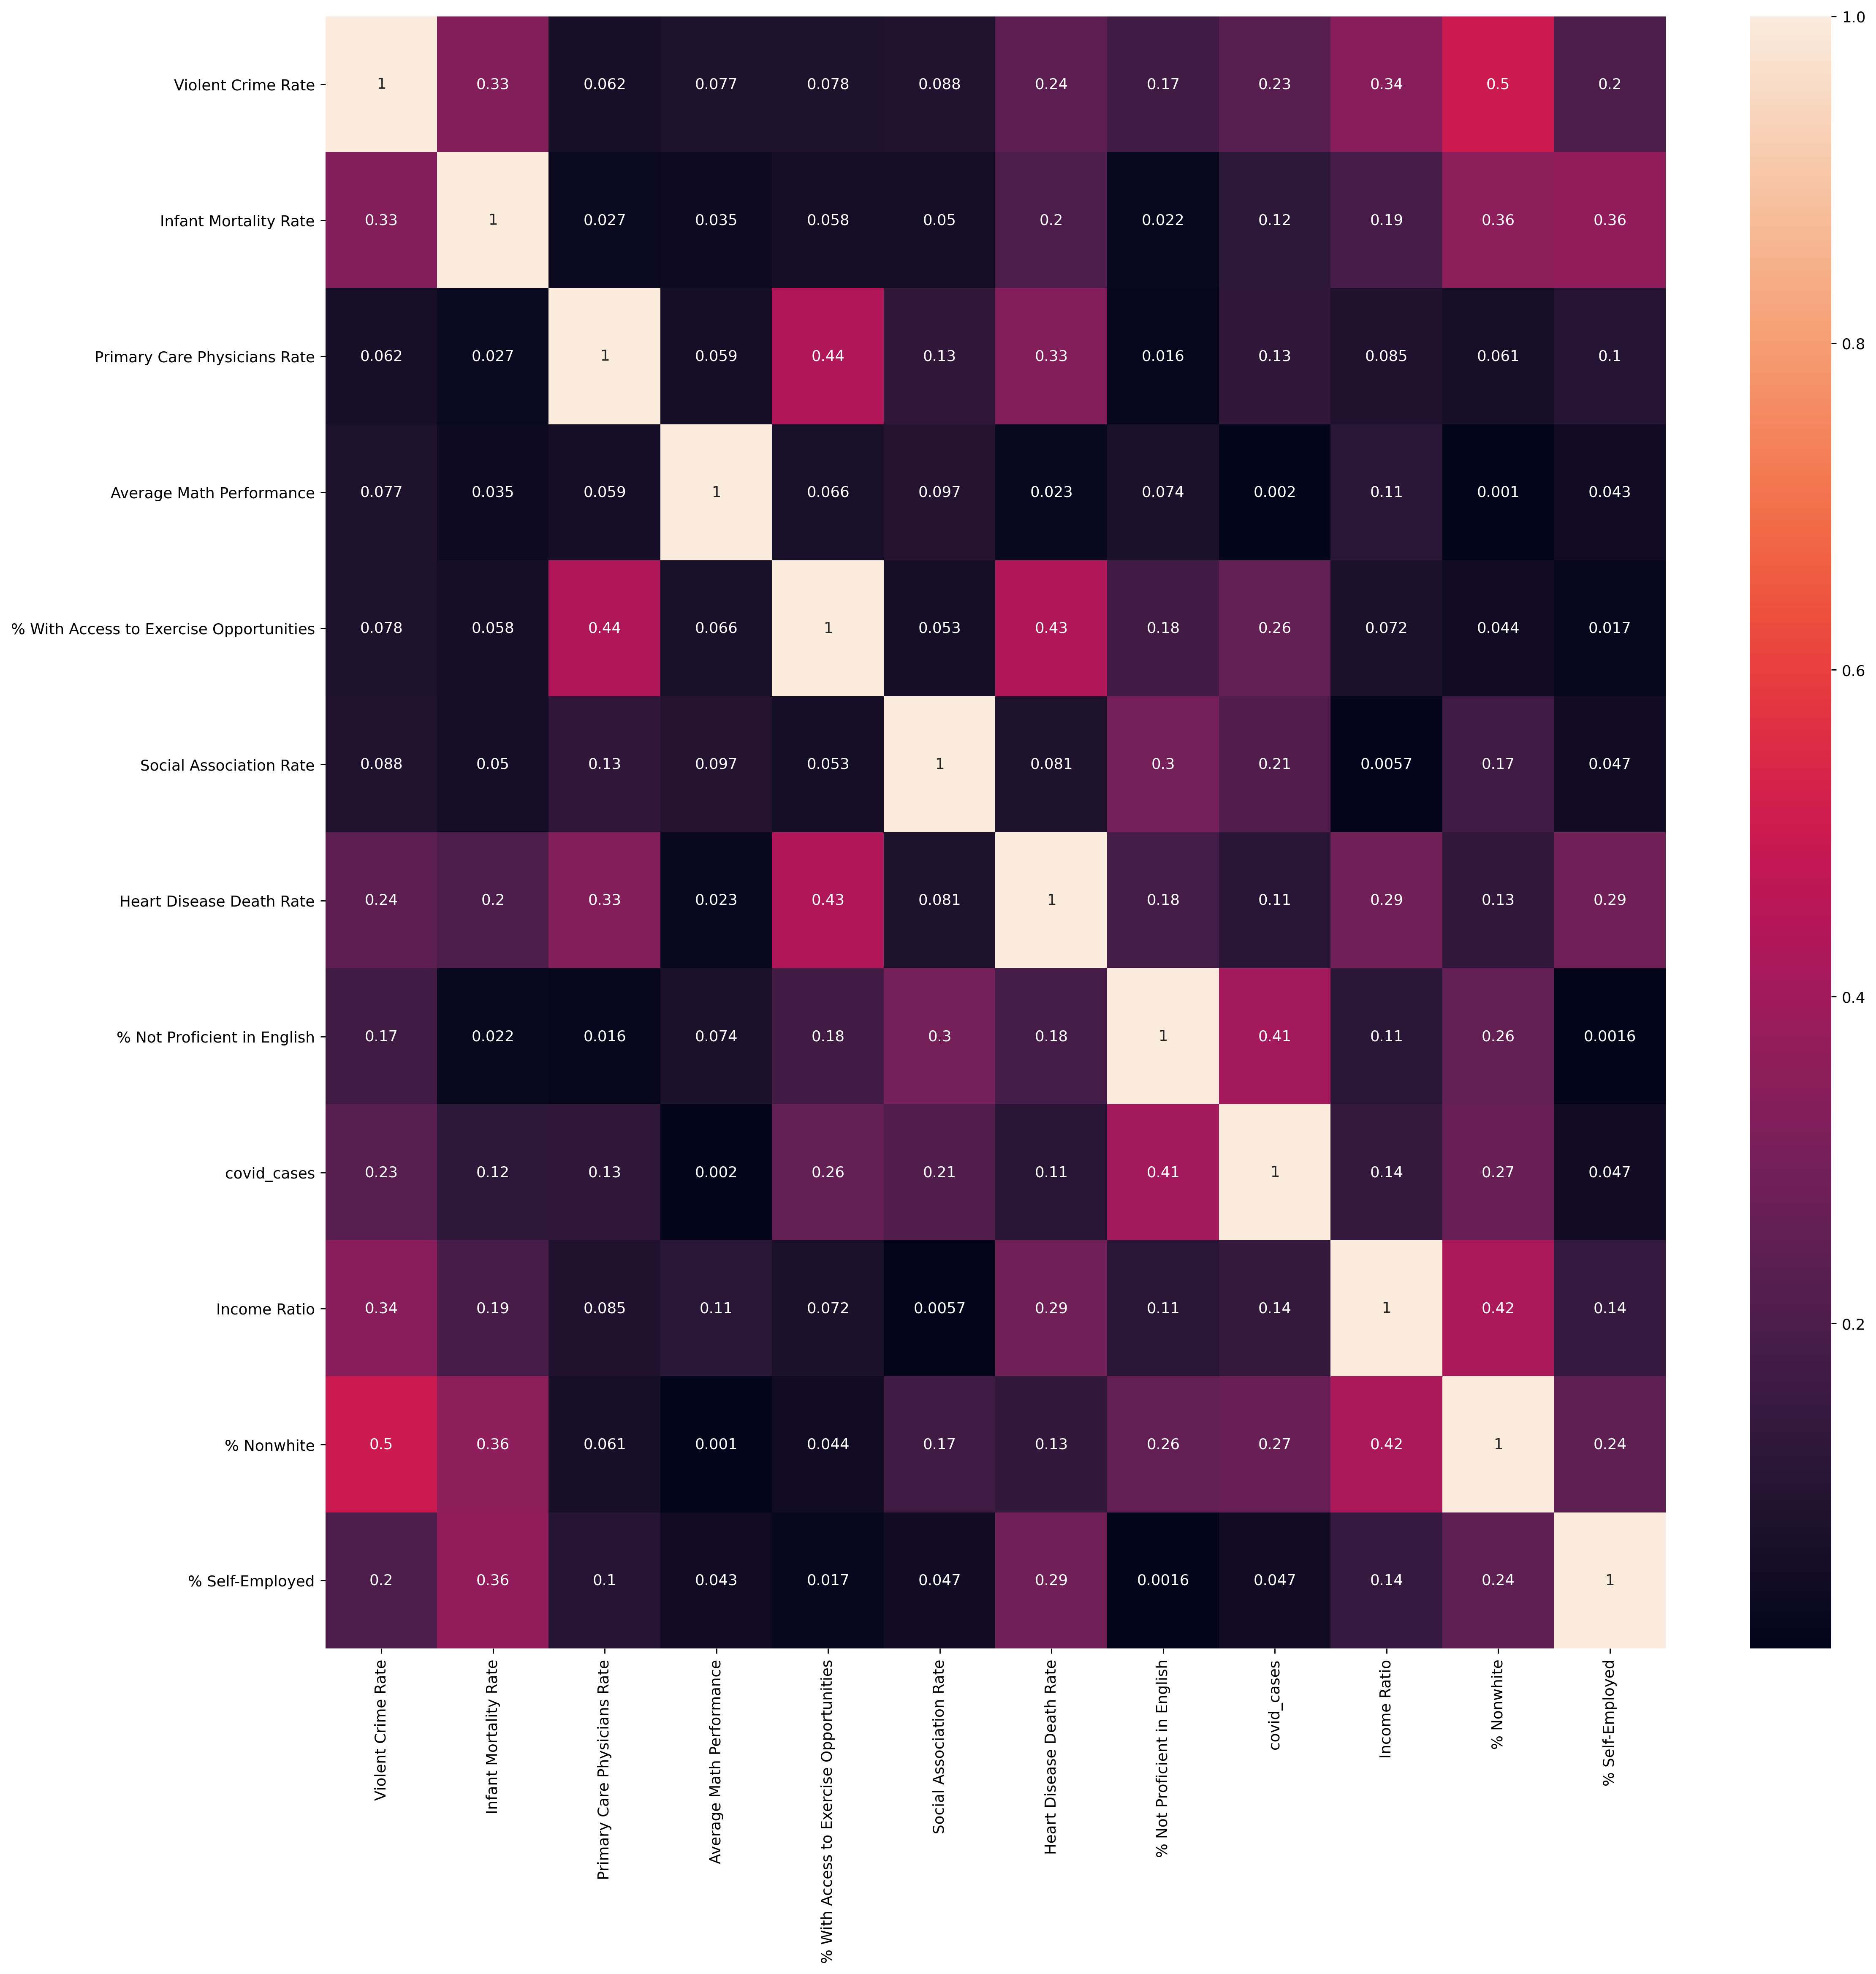

In [30]:
plt.figure(figsize=[20,20],dpi=256)
sns.heatmap(Correlation_Matrix, annot=True)

plt.show()

In [31]:
plt.figure(figsize=[20,20],dpi=400)
a = pps.matrix(X_x).pivot(columns='x', index='y', values='ppscore')
sns.heatmap(a, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)
plt.show()